# KamSol v0.0.2

Authors : Mohit Pundir \& David S. Kammer (ETH Zurich)

## Setup

In [1]:
from IPython.display import clear_output

try:
    import fenics as fe
    print('Using locally installed Fenics')
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import fenics as fe
    clear_output(wait=True)
    print('Fenics Installed Successfully from GitHub')

--------------------------------------------------------------------------
[[51361,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: eu-g5-048-3

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------


Using locally installed Fenics


In [2]:
from IPython.display import display, Image
display(Image(filename="./figs/setup_v01.png", height=800, width=800))

__Assumptions:__ Linear elastic material, small strain, 2D

## Input Data 
- Specifiy the __filename__ that contains the data, model type (__plane stress/plane strain__) and __density__ of the material
- Specify the length along the $x$-axis ($x_{min}, x_{max}$) and the location of the strain gauges ($y_{max})$
- Speciy the number of points along $x$-axis for finite element discretization


In [3]:
filename = 'examples/Data_Eve7.mat'
model    = "plane_stress"

rho_mat  =  1.35  # g/cm3 density

# --------------------
# Dimensions
# --------------------
x_left = -50    #mm  
x_right = 50    #mm                                                         # QUESTION: Songlin: is it possible to go up to 300 mm?
y_top = 5      #mm (Strain gauge location)

nb_points_x = 1000   
refine = 15 # number of rounds of refinement at crack tip (integer)
refine_region = 15 # radius around crack tip to refine (in number of elements)

# -----------------------
# Keywords in matlab file
# -----------------------
keywords = { 'elasticity_modulus' : 'E_PVC_dynamic',
             'poisson_ratio'      : 'nu_PVC',
             'crack_speed'        : 'Cf',
             'strain_x_coords'    : 'x_tip100mm',
             'strain_xx'          : 'Uxx_miliStrain',
             'strain_xy'          : 'Uxy_miliStrain',
             'strain_yy'          : 'Uyy_miliStrain',
             'slip_x_coords'      : 'slip_x',
              'slip_values'       : 'slip_y'}

## Reading the data and computing the solution
- We use Fenics to reconstruct the setup and extract the interface tractions from slip and off-interface strain measurements.
- No need to modify anything in the boxes below

In [4]:
import numpy as np
from scipy import interpolate
import scipy.io
from plot_helper_for_kamsol import *

Number of points along x :  1000
Number of points along y :  50


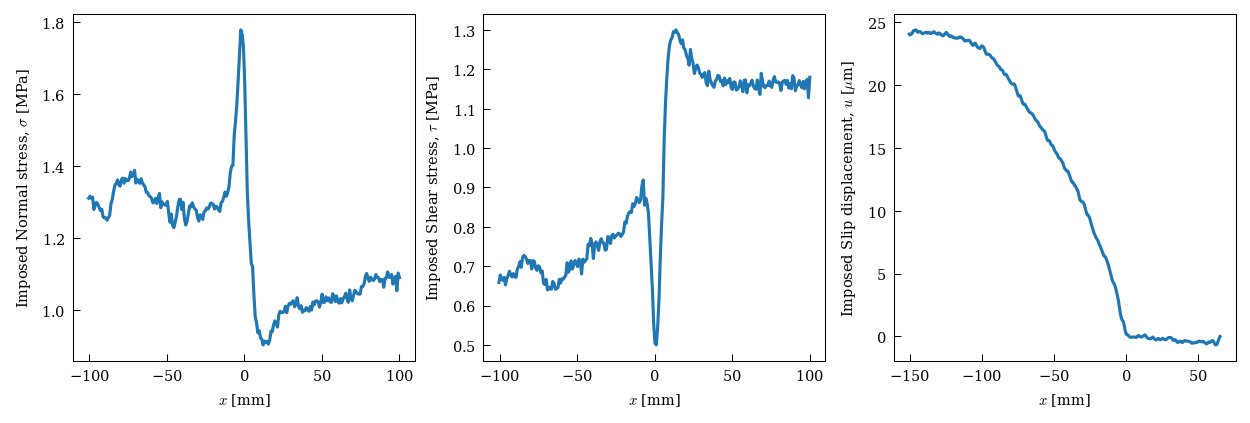

In [5]:
# --------------------
# Dimensions
# --------------------
x_min = x_left*1e-3   #m  
x_max = x_right*1e-3  #m  
y_max = y_top*1e-3    #m (Strain gauge location)

mat = scipy.io.loadmat(filename)

# rupture data
Cf = float(mat[keywords['crack_speed']])       # m/s

# Young's modulus and Poisson's ratio
E = float(mat[keywords['elasticity_modulus']]) # Pa
nu = float(mat[keywords['poisson_ratio']])
rho = rho_mat*1e-3/1e-6  # kg/m3 density

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# Model type
if model == "plane_stress":
    lambda_ = 2*mu*lambda_/(lambda_+2*mu)

nb_points_y = np.maximum(10, int(nb_points_x / (x_max - x_min) * y_max))  # Number of elements

print("Number of points along x : ", nb_points_x)
print("Number of points along y : ", nb_points_y)

# --------------------
# Reading strains
# --------------------

strain_measures = np.zeros([2, 2, len(mat[keywords['strain_x_coords']].flatten())])
strain_measures[0, 0] = mat[keywords['strain_xx']].flatten()                            # QUESTION: Songlin: should this be negative or positive
strain_measures[0, 1] = mat[keywords['strain_xy']].flatten()
strain_measures[1, 0] = mat[keywords['strain_xy']].flatten()
strain_measures[1, 1] = mat[keywords['strain_yy']].flatten()

strain_measures *= 1e-3

# strain to stress 
trace = lambda A : np.einsum('iix  ->x', A)
I2    = lambda A : np.einsum('ij,x',   np.eye(2), A)

stress_val = lambda_*I2(trace(strain_measures)) + 2*mu*strain_measures
stress_spa = mat[keywords['strain_x_coords']].flatten()*1e-3

# --------------------
# Reading slip data
# --------------------
slip_history_spa = mat[keywords['slip_x_coords']].flatten()*1e-3
slip_history_val = mat[keywords['slip_values']].flatten()/2  # slip to displacement for a single material (anti-symmetric setup) 
slip_history_val *= 1e-6


fig, axs = plt.subplots(1, 3, figsize=(10,3))
axs[0].plot(stress_spa*1e3, stress_val[1, 1]*1e-6)
axs[1].plot(stress_spa*1e3, stress_val[0, 1]*1e-6)
axs[2].plot(slip_history_spa*1e3, slip_history_val*1e6)

axs[0].set_xlabel(r'$x~$[mm]')
axs[0].set_ylabel(r'Imposed Normal stress, $\sigma~$[MPa]')
axs[1].set_xlabel(r'$x~$[mm]')
axs[1].set_ylabel(r'Imposed Shear stress, $\tau~$[MPa]')
axs[2].set_xlabel(r'$x~$[mm]')
axs[2].set_ylabel(r'Imposed Slip displacement, $u~$[$\mu$m]')
plt.show()

In [6]:
# this is to check validity of the code
test = False
if test:
    import sys
    from scipy import integrate
    sys.path.append('/cluster/home/dkammer/py-sources/')
    import solidmechanics as sm
    import solidmechanics.lefm as lefm

    # change size of domain to check its affect
    x_max = 0.3
    x_min = -0.1
    nb_points_y = np.maximum(10, int(nb_points_x / (x_max - x_min) * y_max))  # Number of elements
    
    lefm_x = np.linspace(x_min,x_max,2000000)
    
    lefmmat = sm.LinearElasticMaterial({sm.smd.E: E, sm.smd.nu: nu, sm.smd.rho: rho})
    lefmint = {sm.smd.Gamma:1}
    #Cf = 0.01*lefmmat[sm.smd.cR]
    lefm_Sxx,lefm_Syy,lefm_Sxy = lefm.mode_2_subRayleigh_singular_stress_field(Cf,lefmmat,lefmint,
                                                                           x=lefm_x,
                                                                           y=np.ones_like(lefm_x)*y_max,
                                                                           rformat='element-wise')

    # solution
    lefm_Sxx_y0,lefm_Syy_y0,lefm_Sxy_y0 = lefm.mode_2_subRayleigh_singular_stress_field(Cf,lefmmat,lefmint,
                                                                                   x=lefm_x,
                                                                                    y=np.zeros_like(lefm_x),
                                                                               rformat='element-wise')
    stress_y0 = np.zeros([2, 2, len(lefm_x)])
    stress_y0[0,0] = lefm_Sxx_y0
    stress_y0[0,1] = lefm_Sxy_y0
    stress_y0[1,0] = stress_y0[0,1]
    stress_y0[1,1] = lefm_Syy_y0
    
    # for left boundary
    lefm_y = np.linspace(0,y_max,200)
    lefm_Sxx_xmin,lefm_Syy_xmin,lefm_Sxy_xmin = lefm.mode_2_subRayleigh_singular_stress_field(Cf,lefmmat,lefmint, x=np.ones_like(lefm_y)*x_min,y=lefm_y,
                                                                                               rformat='element-wise')
    lefm_Sxx_xmax,lefm_Syy_xmax,lefm_Sxy_xmax = lefm.mode_2_subRayleigh_singular_stress_field(Cf,lefmmat,lefmint, x=np.ones_like(lefm_y)*x_max,y=lefm_y,
                                                                                               rformat='element-wise')
    
    # for slip displacement
    lefm_Vx, lefm_Vy = lefm.mode_2_subRayleigh_singular_velocity_field(Cf,lefmmat,lefmint,
                                                                       x=lefm_x,
                                                                       y=np.zeros_like(lefm_x),
                                                                       rformat='element-wise')

    lefm_Ux = np.flip(integrate.cumtrapz(np.flip(lefm_Vx), lefm_x, initial=0)) / Cf
    lefm_Ux -= np.nanmin(lefm_Ux[lefm_Ux != -np.inf])  # integral starts from -inf -> shift up
    lefm_Ux[lefm_Ux == -np.inf] = 0  # replace -inf with zeros

    lefm_Uy = np.flip(integrate.cumtrapz(np.flip(lefm_Vy), lefm_x, initial=0)) / Cf
    lefm_Uy -= np.nanmax(lefm_Uy[lefm_Uy != -np.inf])  # integral starts from -inf -> shift up
    lefm_Uy[lefm_Uy == -np.inf] = 0  # replace -inf with zeros
    
    stress_spa = lefm_x
    stress_val = np.zeros([2, 2, len(stress_spa)])
    stress_val[0,0] = lefm_Sxx
    stress_val[1,1] = lefm_Syy
    stress_val[0,1] = lefm_Sxy
    stress_val[1,0] = stress_val[0,1]

    slip_history_spa = lefm_x
    slip_history_val = lefm_Ux

    fig, axs = plt.subplots(1, 3, figsize=(10,3))
    axs[0].plot(lefm_x*1e3, stress_val[1, 1]*1e-6)
    axs[1].plot(lefm_x*1e3, stress_val[0, 1]*1e-6)
    axs[2].plot(lefm_x*1e3, lefm_Uy*1e6)#slip_history_val*1e6,'o')

    axs[0].set_xlabel(r'$x~$[mm]')
    axs[0].set_ylabel(r'Imposed Normal stress, $\sigma~$[MPa]')
    axs[1].set_xlabel(r'$x~$[mm]')
    axs[1].set_ylabel(r'Imposed Shear stress, $\tau~$[MPa]')
    axs[2].set_xlabel(r'$x~$[mm]')
    axs[2].set_ylabel(r'Imposed Slip displacement, $u~$[$\mu$m]')
    plt.show()

In [7]:
# --------------------
# Functions and classes
# --------------------
fe.set_log_level(40)

# Strain function
def epsilon(u):
    return fe.sym(fe.grad(u))

# Stress function
def sigma(u):
    return lambda_*fe.tr(epsilon(u))*fe.Identity(2) + 2*mu*epsilon(u)

# class to apply non-uniform Dirichlet BC
class BCFromSlip(fe.UserExpression):
    def __init__(self,xdata,vdata, **kwargs):
        super().__init__(**kwargs)
        self.xdata = xdata
        self.vdata = vdata
        self.fx = interpolate.interp1d(xdata, vdata)
        
    def eval(self,value,x):
        value[0] = self.fx(x[0])
        value[1] = 0
 
    def value_shape(self):
        return (2, )      
        
class BCFromStress(fe.UserExpression):
    def __init__(self,xdata,vxdata,vydata,**kwargs):
        super().__init__(**kwargs)
        self.xdata = xdata
        self.vxdata = vxdata
        self.vydata = vydata
        self.fx = interpolate.interp1d(xdata, vxdata)
        self.fy = interpolate.interp1d(xdata, vydata)
        
    def eval(self,value,x):
        value[0] = self.fx(x[0])
        value[1] = self.fy(x[0])

    def value_shape(self):
        return (2, )

class BCSide(fe.UserExpression):
    def __init__(self,ydata,vxdata,vydata,**kwargs):
        super().__init__(**kwargs)
        self.ydata = ydata
        self.vxdata = vxdata
        self.vydata = vydata
        self.fx = interpolate.interp1d(ydata, vxdata)
        self.fy = interpolate.interp1d(ydata, vydata)
        
    def eval(self,value,x):
        value[0] = self.fx(x[1])
        value[1] = self.fy(x[1])

    def value_shape(self):
        return (2, )

    
# refine mesh
def refine_mesh(mesh, center, dist): 
    # Mark cells for refinement
    cell_markers = fe.MeshFunction("bool", mesh, mesh.topology().dim())
    for c in fe.cells(mesh):
        cmid = c.midpoint()
        delta = np.sqrt((cmid[0]-center[0])**2 + 
                        (cmid[1]-center[1])**2)
        if delta < dist:
            cell_markers[c] = True
        else:
            cell_markers[c] = False
    # Refine mesh
    return fe.refine(mesh, cell_markers)

# --------------------
# Geometry
# --------------------
mesh = fe.RectangleMesh(fe.Point(x_min+fe.DOLFIN_EPS, 0.0), fe.Point(x_max-fe.DOLFIN_EPS, y_max), nb_points_x, nb_points_y)

# refine around the crack
for i in range(refine):
    mesh = refine_mesh(mesh, center=(0,0), dist=refine_region*(x_max-x_min)/nb_points_x/np.power(2,i))
    
# --------------------
# Boundaries
# --------------------
boundaries = fe.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

top = fe.CompiledSubDomain("near(x[1], l_y) && on_boundary", l_y=y_max)
top.mark(boundaries, 1)
left = fe.CompiledSubDomain("near(x[0],l_x) && on_boundary", l_x=x_min+fe.DOLFIN_EPS)
left.mark(boundaries,2)
right = fe.CompiledSubDomain("near(x[0],l_x) && on_boundary", l_x=x_max-fe.DOLFIN_EPS)
right.mark(boundaries,3)
ds = fe.ds(subdomain_data=boundaries)

bottom = fe.CompiledSubDomain("near(x[1], 0) && on_boundary")

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 1)
u = fe.Function(V, name='Displacment')
du = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
slip_bc = BCFromSlip(slip_history_spa, slip_history_val)
bcbx = fe.DirichletBC(V, slip_bc, bottom)
bcs = [bcbx]

traction = BCFromStress(stress_spa,
                        stress_val[0, 1],
                        stress_val[1, 1])

# side boundary conditions via tractions
if test:
    left_traction = BCSide(lefm_y, lefm_Sxx_xmin, -lefm_Sxy_xmin)
    righ_traction = BCSide(lefm_y, lefm_Sxx_xmax, lefm_Sxy_xmax)

# --------------------
# Weak form
# --------------------
a = fe.inner(sigma(du), epsilon(u_test))*fe.dx + rho*Cf**2*fe.inner(fe.grad(du), fe.grad(u_test))*fe.dx
l = fe.dot(traction, u_test)*ds(1)
if test:
    l += fe.dot(left_traction, u_test)*ds(2)
    l += fe.dot(righ_traction, u_test)*ds(3)

# --------------------
# Solver
# --------------------
fe.solve(a == l, u, bcs,
      solver_parameters={'linear_solver': 'gmres',
                         'preconditioner': 'ilu'})
print('solver: done')

solver: done


## Saving results
Inteface data ($x ~[mm], y~ [mm], u_x ~[\mu m], u_y~[\mu m], \sigma_{xx}~ [MPa], \sigma_{xy}~ [MPa], \sigma_{yy}~ [MPa]$) is saved in matlab format. 

In [8]:
# --------------------
# Post-process
# --------------------

# compute stresses
stress = sigma(u)
V0 = fe.TensorFunctionSpace(mesh, "DG", 0)
nodal_stress = fe.project(stress, V0)   

# plot along boundary
is_bot = lambda d: d[:,1] < 1e-12 
is_top = lambda d: d[:,1] > y_max - 1e-12

# choose here
is_on_bc = lambda d: is_bot(d)

# extract u at boundary
coords = mesh.coordinates()
indices_bot = np.argwhere(is_on_bc(coords)).flatten()
u_xys = coords[indices_bot,:]
indices_sort = np.argsort(u_xys[:,0])
u_xys = u_xys[indices_sort]
u_val_x = u.sub(0).compute_vertex_values()[indices_bot][indices_sort]
u_val_y = u.sub(1).compute_vertex_values()[indices_bot][indices_sort]
u_val = [u_val_x,u_val_y]

# get stresses at nodal position
sigma_val = np.array([nodal_stress(i) for i in u_xys])

# ---------------------------------------------------------
# saving interface stress and displacement in matlab format
# ---------------------------------------------------------
from scipy.io import savemat

to_dump = np.zeros((len(u_xys[:,0]), 7))
to_dump[:, 0] = u_xys[:,0]*1e-3                # x coordinate converted to mm
to_dump[:, 1] = u_xys[:,1]*1e-3                # y coordinate converted to mm
to_dump[:, 2] = u_val_x*1e-6                   # convert to mu-m
to_dump[:, 3] = u_val_y*1e-6                   # convert to mu-m

for i in  range(2):
    for j in range(2):
        sc = tuple((i, j))
        to_dump[:, 4+i+j] = sigma_val[:,sc[1]*mesh.geometry().dim()+sc[0]] * 1e-6 # convert to MPa
         
mdic = {"x": to_dump[:, 0], 
        "y": to_dump[:, 1],
       'u_x' : to_dump[:, 2],
       'u_y' : to_dump[:, 3],
       'sigma_xx' : to_dump[:, 4],
       'sigma_xy' : to_dump[:, 5], 
       'sigma_yy' : to_dump[:, 6]}

filenames = filename.split('.')
savemat(filenames[-2] + "_interface_data." + filenames[-1], mdic)
print('saved')

saved


In [9]:
# ---------------------------------------------------------
# saving full stress and displacement in matlab format
# ---------------------------------------------------------

# extract u everywhere
u_val_x_full = u.sub(0).compute_vertex_values()
u_val_y_full = u.sub(1).compute_vertex_values()

# get stresses at nodal position
sigma_val_full = np.array([nodal_stress(i) for i in coords])

# prepare dump
to_dump = np.zeros((len(coords[:,0]), 7))
to_dump[:, 0] = coords[:,0]*1e-3                # x coordinate converted to mm
to_dump[:, 1] = coords[:,1]*1e-3                # y coordinate converted to mm
to_dump[:, 2] = u_val_x_full*1e-6               # convert to mu-m
to_dump[:, 3] = u_val_y_full*1e-6               # convert to mu-m

for i in  range(2):
    for j in range(2):
        sc = tuple((i, j))
        to_dump[:, 4+i+j] = sigma_val_full[:,sc[1]*mesh.geometry().dim()+sc[0]] * 1e-6  # convert to MPa
         
mdic = {"x": to_dump[:, 0], 
        "y": to_dump[:, 1],
       'u_x' : to_dump[:, 2],
       'u_y' : to_dump[:, 3],
       'sigma_xx' : to_dump[:, 4],
       'sigma_xy' : to_dump[:, 5], 
       'sigma_yy' : to_dump[:, 6]}

filenames = filename.split('.')
savemat(filenames[-2] + "_full_data." + filenames[-1], mdic)

del u_val_x_full, u_val_y_full, sigma_val_full, to_dump, mdic  # free memory
print('saved')

saved


## Plotting full model

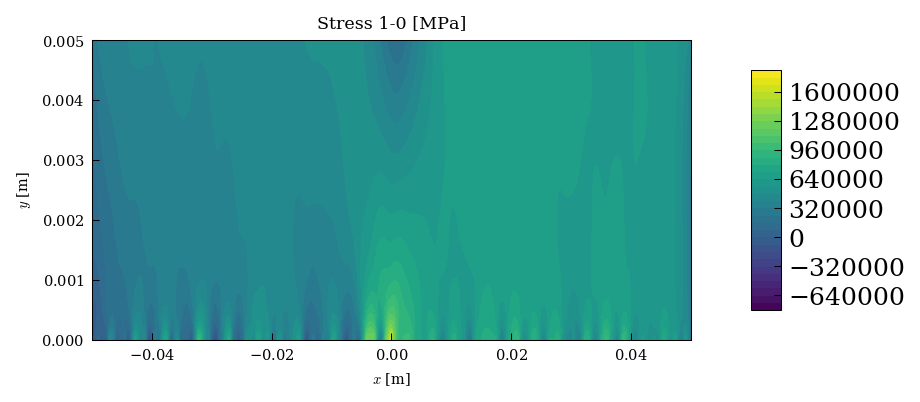

In [10]:
for i in range(mesh.geometry().dim()):
    fig= plt.figure(figsize=(6,6), constrained_layout=True)
    axe = plt.axes()
    sf = fe.plot(u.sub(i)*1e6,title='Displacement {} [$\mu m$]'.format(i))
    aspect = 2
    axe.set_aspect(abs((x_max - x_min)/(y_max))/aspect)
    axins1 = axe.inset_axes([1.1, 0.1, 0.05, 0.8])
    cbar = fig.colorbar(sf, cax=axins1, pad=0.1, fraction=0.1)
    cbar.ax.locator_params(nbins=10)
    cbar.ax.tick_params(labelsize=12) 
    axe.set_xlabel(r'$x$ [m]')
    axe.set_ylabel(r'$y$ [m]')
        
for i in range(mesh.geometry().dim()):
    for j in range(mesh.geometry().dim()):
        fig= plt.figure(figsize=(6,6), constrained_layout=True)
        axe = plt.axes()
        sf = fe.plot(nodal_stress[i, j],title=r"Stress {}-{} [MPa]".format(i,j))
        aspect = 2
        axe.set_aspect(abs((x_max - x_min)/(y_max))/aspect)
        axins1 = axe.inset_axes([1.1, 0.1, 0.05, 0.8])
        cbar = fig.colorbar(sf, cax=axins1,  pad=0.1, fraction=0.1)
        cbar.ax.locator_params(nbins=10)
        cbar.ax.tick_params(labelsize=12) 
        axe.set_xlabel(r'$x$ [m]')
        axe.set_ylabel(r'$y$ [m]')

## Plotting interface data
- Choose the displacement and the stress compnent along the interface

In [11]:
u_comp = 0              # displacement component 
sig_comp = tuple((0,1)) # stress component 

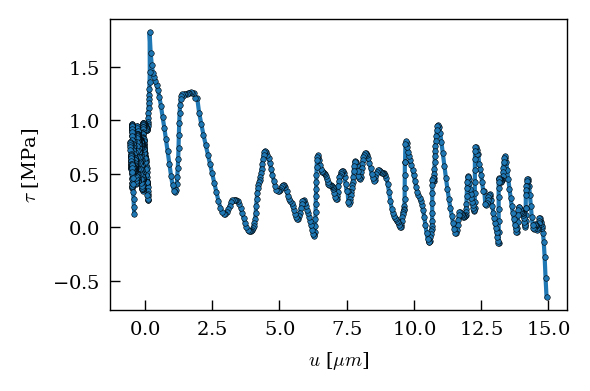

In [12]:
fig = plt.figure(figsize=set_size(fraction=0.4, height_ratio=0.65), dpi=200, constrained_layout=True)
ax = fig.add_subplot(111)
ax.plot(u_xys[:,0],u_val[u_comp]*1e6,'o-',label='Displacement {} [$\mu m$]'.format(u_comp), markersize=1.5, markeredgecolor='k', markeredgewidth=0.2)
ax.legend(loc='best')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$u$ [$\mu m$]')
#ax.set_ylim([0,0.3]) # to be deleted
#ax.set_xlim([-0.0001,0.0001]) # to be deleted

fig = plt.figure(figsize=set_size(fraction=0.4, height_ratio=0.65), dpi=200, constrained_layout=True)
ax = fig.add_subplot(111)
ax.plot(u_xys[:,0],sigma_val[:,sig_comp[1]*mesh.geometry().dim()+sig_comp[0]]*1e-6,'o-',label='Stress {}'.format(sig_comp), markersize=2,
        markeredgecolor='k', markeredgewidth=0.2)
if test:
    ax.plot(stress_spa, stress_y0[sig_comp[0], sig_comp[1]]*1e-6,'k-')
ax.legend(loc='best')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$\sigma$ or $\tau$ [MPa]')
if test:
    #ax.set_ylim([-1,2])
    ax.set_xlim([-0.00002,0.00002])


fig = plt.figure(figsize=set_size(fraction=0.4, height_ratio=0.65), dpi=200, constrained_layout=True)
ax = fig.add_subplot(111)
ax.plot(u_val[u_comp]*1e6, sigma_val[:,sig_comp[1]*mesh.geometry().dim()+sig_comp[0]]*1e-6, 'o-', markersize=2,
        markeredgecolor='k', markeredgewidth=0.2)
ax.set_xlabel(r'$u$ [$\mu m$]')
ax.set_ylabel(r'$\tau$ [MPa]')
if test:
    #ax.set_ylim([-1,2])
    ax.set_xlim([-0.05,0.5])

plt.show()

## Normal stress at the interface

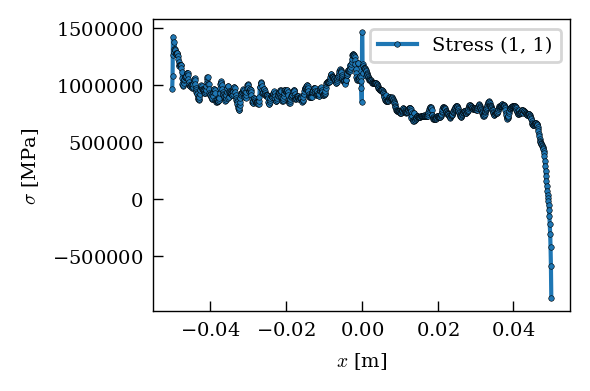

In [13]:
normal_comp = tuple((1,1)) # stress component 

fig = plt.figure(figsize=set_size(fraction=0.4, height_ratio=0.65), dpi=200, constrained_layout=True)
ax = fig.add_subplot(111)
ax.plot(u_xys[:,0],sigma_val[:,normal_comp[1]*mesh.geometry().dim()+normal_comp[0]],'o-',label='Stress {}'.format(normal_comp), markersize=2,
        markeredgecolor='k', markeredgewidth=0.2)
if test:
    ax.plot(stress_spa, stress_y0[normal_comp[0], normal_comp[1]],'k-',linewidth=0.5)
ax.legend(loc='best')
ax.set_xlabel(r'$x$ [m]')
ax.set_ylabel(r'$\sigma$ [MPa]')
if test:
    #ax.set_xlim([])
    ax.set_ylim([-10000,100000])

plt.show()